#### This notebook contains experiments using different statistical models using combinations of smokeynet predictions, goes16 and goes17 predictions

In [23]:
import pandas as pd
import urllib.request
import datetime as dt
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from haversine import haversine, Unit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pytz
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score
import os
import glob
import matplotlib.pyplot as plt
import lightgbm as lgb
p = print

## Compute Basic Baseline Statistics

In [10]:
# processed_data_dir = "../../data/processed/wfabba"
# processed_data_dir = "../../data/processed/wfabba_sliding/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_20min/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_new_data/"
processed_data_dir = "../../data/processed/wfabba_sliding_window_new_split/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_without_code_15/"
csv_suffix = "_all_hard_voting_35_window_20.csv"
# csv_suffix = "_all_hard_voting_35.csv"

csv_files = glob.glob(os.path.join(processed_data_dir, f"*{csv_suffix}"))
  
master_df = pd.DataFrame()
    
# loop over the list of csv files
for f in csv_files:
    df = pd.read_csv(f)
    df["file"] = f
    master_df = pd.concat([master_df, df])
    
master_df = master_df.reset_index()
master_df = master_df.drop(columns=["index", "Unnamed: 0"])
# master_df
master_df = master_df.rename(columns={"image_pred":"smokeynet_pred", "final_pred":"majority_vote_pred"})
# master_df
# get only the test data
master_copy_df = master_df[master_df["type"] == "test"].copy()
valid_copy_df = master_df[master_df["type"] == "valid"].copy()

# if either one of the 2 has code 15, let it remain in the df
condition = ((~master_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)
valid_condition = ((~valid_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)

# Calculate the baseline accuracies of the individual models and the hard vote ensemble
image_labels = master_copy_df[condition]["image_gt"]
smokeynet_preds = master_copy_df[condition]["smokeynet_pred"]
goes16_preds = master_copy_df[condition]["goes16_pred"]
goes17_preds = master_copy_df[condition]["goes17_pred"]
hard_vote_ensemble_preds = master_copy_df[condition]["majority_vote_pred"]

# Computing on Validation Set
# image_labels = valid_copy_df[valid_condition]["image_gt"]
# smokeynet_preds = valid_copy_df[valid_condition]["smokeynet_pred"]
# goes16_preds = valid_copy_df[valid_condition]["goes16_pred"]
# goes17_preds = valid_copy_df[valid_condition]["goes17_pred"]
# hard_vote_ensemble_preds = valid_copy_df[valid_condition]["majority_vote_pred"]

smokeynet_baseline_score = accuracy_score(image_labels, smokeynet_preds)
goes16_baseline_score = accuracy_score(image_labels, goes16_preds)
goes17_baseline_score = accuracy_score(image_labels, goes17_preds)
hard_vote_ensemble_score = accuracy_score(image_labels, hard_vote_ensemble_preds)

print("Baseline score SmokeyNet:", smokeynet_baseline_score)
print("Baseline score GOES-16:", goes16_baseline_score)
print("Baseline score GOES-17:", goes17_baseline_score)
print("Hard Vote Ensemble score:", hard_vote_ensemble_score)

Baseline score SmokeyNet: 0.8220704529115744
Baseline score GOES-16: 0.6187994248741913
Baseline score GOES-17: 0.6063982746225737
Hard Vote Ensemble score: 0.6527677929547089


## Plot Confusion Matrices

Text(0.5, 1.0, 'GOES 17')

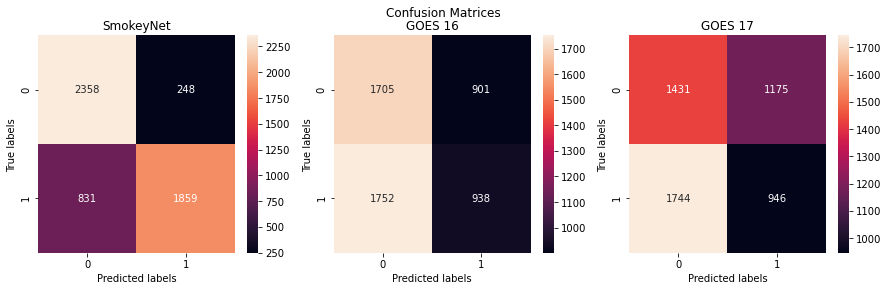

<Figure size 720x2880 with 0 Axes>

In [12]:
# p ("Code counts", master_df["WFABBA_GOES16_Code"].count(), master_df["WFABBA_GOES17_Code"].count(), master_df.shape[0], "\n\n")
# p ("GOES16 pred vs GT counts\n", master_df["goes16_pred"].value_counts(), "\n", master_df["image_gt"].value_counts(), "\n\n")
# p ("GOES16 pred vs GT counts\n", master_df["goes17_pred"].value_counts(), "\n", master_df["image_gt"].value_counts())

from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(image_labels, smokeynet_preds), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(image_labels, goes16_preds), annot=True, fmt='g', ax=ax2)
sn.heatmap(confusion_matrix(image_labels, goes17_preds), annot=True, fmt='g', ax=ax3)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet') 
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('GOES 16')
ax3.set_xlabel('Predicted labels')
ax3.set_ylabel('True labels') 
ax3.set_title('GOES 17')
# plt.show()

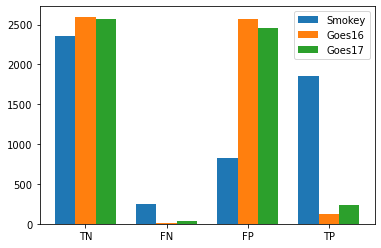

In [4]:
import numpy as np
column_names = ["TN", "FN", "FP", "TP"]
numbers = [
    np.array(confusion_matrix(image_labels, smokeynet_preds)).ravel(),
    np.array(confusion_matrix(image_labels, goes16_preds)).ravel(),
    np.array(confusion_matrix(image_labels, goes17_preds)).ravel()
]
index = np.arange(len(column_names)) + 0.3
width = 0.25
bar1 = plt.bar(index, numbers[0], width)
bar2 = plt.bar(index+width, numbers[1], width)
bar3 = plt.bar(index+width*2, numbers[2], width)
  
plt.xticks(index+width,column_names)
plt.legend( (bar1, bar2, bar3), ('Smokey', 'Goes16', 'Goes17') )
plt.show()

### For the incorrect goes16 predictions, how many are code 15? --> where gt = 0 and goes16 = 1

In [24]:
p ("Including code 15")
p (master_copy_df[(~master_copy_df["image_gt"].isna()) 
        & (master_copy_df.image_gt == 0) 
        & (master_copy_df.goes16_pred == 1)
]['WFABBA_GOES16_Code'].value_counts())

p ("Excluding code 15")
p (master_copy_df[condition 
        & (master_copy_df.image_gt == 0) 
        & (master_copy_df.goes16_pred == 1)
]['WFABBA_GOES16_Code'].value_counts())



Including code 15
10.0    295
15.0    171
12.0     51
Name: WFABBA_GOES16_Code, dtype: int64
Excluding code 15
10.0    295
15.0    171
12.0     51
Name: WFABBA_GOES16_Code, dtype: int64


### For the incorrect goes17 predictions, how many are code 15? --> where gt = 0 and goes17 = 1

In [34]:
p ("Including code 15")
p (master_copy_df[(~master_copy_df["image_gt"].isna()) 
        & (master_copy_df.image_gt == 0) 
        & (master_copy_df.goes17_pred == 1)
]['WFABBA_GOES17_Code'].value_counts())

p ("Excluding code 15")
p (master_copy_df[condition 
        & (master_copy_df.image_gt == 0) 
        & (master_copy_df.goes17_pred == 1)
]['WFABBA_GOES17_Code'].value_counts())



Including code 15
15.0    202
10.0    113
12.0      9
Name: WFABBA_GOES17_Code, dtype: int64
Excluding code 15
10.0    66
12.0     9
Name: WFABBA_GOES17_Code, dtype: int64


### Goes prediction != gt (FN + FP)

In [38]:
p ("Including code 15")
p (master_copy_df[(~master_copy_df["image_gt"].isna()) 
        & (master_copy_df.image_gt != master_copy_df.goes16_pred)
]['image_gt'].count())

p ("Excluding code 15")
p (master_copy_df[condition 
        & (master_copy_df.image_gt != master_copy_df.goes16_pred)
]['image_gt'].count())

p ("Including code 15")
p (master_copy_df[(~master_copy_df["image_gt"].isna()) 
        & (master_copy_df.image_gt != master_copy_df.goes17_pred)
]['image_gt'].count())

p ("Excluding code 15")
p (master_copy_df[condition 
        & (master_copy_df.image_gt != master_copy_df.goes17_pred)
]['image_gt'].count())

Including code 15
2168
Excluding code 15
1989
Including code 15
2162
Excluding code 15
1891


In [48]:
p (master_copy_df[
    (master_copy_df.image_gt == master_copy_df.goes16_pred)
    & (master_copy_df.image_gt != master_copy_df.smokeynet_pred)
]['WFABBA_GOES16_Code'].value_counts())

p (master_copy_df[
    (master_copy_df.image_gt == master_copy_df.goes17_pred)
    & (master_copy_df.image_gt != master_copy_df.smokeynet_pred)
]['WFABBA_GOES17_Code'].value_counts())

10.0    84
15.0     7
12.0     3
Name: WFABBA_GOES16_Code, dtype: int64
10.0    131
15.0     52
14.0      3
13.0      3
Name: WFABBA_GOES17_Code, dtype: int64


In [11]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean, std
from sklearn.preprocessing import OneHotEncoder
import numpy as np

### Smokeynet predictions + GOES predictions

In [31]:

x = master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred']].astype(int)
y = master_df['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False)
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.810 (0.010)
>sgd_squared_hinge 0.810 (0.009)
>sgd_hinge 0.810 (0.009)
>svm 0.810 (0.009)
>adaboost 0.810 (0.009)
>k_nearest_7 0.748 (0.086)
>k_nearest_5 0.745 (0.089)
>k_nearest_10 0.748 (0.078)
>xgboost 0.810 (0.009)


### Smokeynet + GOES data predictions + GOES codes

In [32]:
# x_train, x_test, y_train, y_test = train_test_split(
#     master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred']].astype(int),
#     master_df['image_gt'].astype(int),
#     test_size=0.2
# )
x = master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred', 'WFABBA_GOES16_Code', 'WFABBA_GOES17_Code']]#.astype(int)
x = x.fillna(-1).astype(int)
x = pd.get_dummies(x, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
# p (x.WFABBA_GOES16_Code_10.value_counts())
y = master_df['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False)
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.811 (0.010)
>sgd_squared_hinge 0.813 (0.010)
>sgd_hinge 0.814 (0.009)
>svm 0.820 (0.010)
>adaboost 0.810 (0.009)
>k_nearest_7 0.755 (0.086)
>k_nearest_5 0.751 (0.089)
>k_nearest_10 0.755 (0.078)
>xgboost 0.820 (0.010)


### Predictions using only the GOES data --> smokeynet considered as a separate model

In [33]:
x = master_df[['goes16_pred', 'goes17_pred', 'WFABBA_GOES16_Code', 'WFABBA_GOES17_Code']]#.astype(int)
x = x.fillna(-1).astype(int)
x = pd.get_dummies(x, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
# p (x.WFABBA_GOES16_Code_10.value_counts())
y = master_df['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False)
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.627 (0.010)
>sgd_squared_hinge 0.630 (0.011)
>sgd_hinge 0.631 (0.011)
>svm 0.628 (0.010)
>adaboost 0.610 (0.011)
>k_nearest_7 0.592 (0.051)
>k_nearest_5 0.597 (0.048)
>k_nearest_10 0.619 (0.023)
>xgboost 0.628 (0.010)


### Include supplemental GOES data

In [12]:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x]
master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred', 'image_prob'] + extra_cols]
# master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred'] + extra_cols]

# p ("FRP", master_df.WFABBA_GOES16_FRP.min(), master_df.WFABBA_GOES16_FRP.max(), sum(master_df.WFABBA_GOES16_FRP.isna()))
# p ("Fire Temp", master_df.WFABBA_GOES16_Fire_Temp.min(), master_df.WFABBA_GOES16_Fire_Temp.max(), sum(master_df.WFABBA_GOES16_Fire_Temp.isna()))
# p ("Pixel Size", master_df.WFABBA_GOES16_Pixel_Size.min(), master_df.WFABBA_GOES16_Pixel_Size.max(), sum(master_df.WFABBA_GOES16_Pixel_Size.isna()))
# p ("Obs BT4", master_df.WFABBA_GOES16_Obs_BT4.min(), master_df.WFABBA_GOES16_Obs_BT4.max(), sum(master_df.WFABBA_GOES16_Obs_BT4.isna()))
# p ("Obs BT11", master_df.WFABBA_GOES16_Obs_BT11.min(), master_df.WFABBA_GOES16_Obs_BT11.max(), sum(master_df.WFABBA_GOES16_Obs_BT11.isna()))
# p ("Bkg BT4", master_df.WFABBA_GOES16_Bkg_BT4.min(), master_df.WFABBA_GOES16_Bkg_BT4.max(), sum(master_df.WFABBA_GOES16_Bkg_BT4.isna()))
# p ("Bkg BT11", master_df.WFABBA_GOES16_Bkg_BT11.min(), master_df.WFABBA_GOES16_Bkg_BT11.max(), sum(master_df.WFABBA_GOES16_Bkg_BT11.isna()))

master_df.WFABBA_GOES16_FRP = master_df.WFABBA_GOES16_FRP.fillna(master_df.WFABBA_GOES16_FRP.mode()[0]).astype(float)
# This is set to -999 if the subpixel fire temperature is less than 400 K at the end of the algorithm.
master_df.WFABBA_GOES16_Fire_Temp = master_df.WFABBA_GOES16_Fire_Temp.fillna(-9999.0).astype(float)
master_df.WFABBA_GOES16_Pixel_Size = master_df.WFABBA_GOES16_Pixel_Size.fillna(master_df.WFABBA_GOES16_Pixel_Size.mean()).astype(float)
master_df.WFABBA_GOES16_Obs_BT4 = master_df.WFABBA_GOES16_Obs_BT4.fillna(master_df.WFABBA_GOES16_Obs_BT4.mean()).astype(float)
master_df.WFABBA_GOES16_Obs_BT11 = master_df.WFABBA_GOES16_Obs_BT11.fillna(master_df.WFABBA_GOES16_Obs_BT11.mean()).astype(float)
master_df.WFABBA_GOES16_Bkg_BT4 = master_df.WFABBA_GOES16_Bkg_BT4.fillna(master_df.WFABBA_GOES16_Bkg_BT4.mean()).astype(float)
master_df.WFABBA_GOES16_Bkg_BT11 = master_df.WFABBA_GOES16_Bkg_BT11.fillna(master_df.WFABBA_GOES16_Bkg_BT11.mean()).astype(float)

master_df.WFABBA_GOES17_FRP = master_df.WFABBA_GOES17_FRP.fillna(master_df.WFABBA_GOES17_FRP.mode()[0]).astype(float)
# This is set to -999 if the subpixel fire temperature is less than 400 K at the end of the algorithm.
master_df.WFABBA_GOES17_Fire_Temp = master_df.WFABBA_GOES17_Fire_Temp.fillna(-9999.0).astype(float)
master_df.WFABBA_GOES17_Pixel_Size = master_df.WFABBA_GOES17_Pixel_Size.fillna(master_df.WFABBA_GOES17_Pixel_Size.mean()).astype(float)
master_df.WFABBA_GOES17_Obs_BT4 = master_df.WFABBA_GOES17_Obs_BT4.fillna(master_df.WFABBA_GOES17_Obs_BT4.mean()).astype(float)
master_df.WFABBA_GOES17_Obs_BT11 = master_df.WFABBA_GOES17_Obs_BT11.fillna(master_df.WFABBA_GOES17_Obs_BT11.mean()).astype(float)
master_df.WFABBA_GOES17_Bkg_BT4 = master_df.WFABBA_GOES17_Bkg_BT4.fillna(master_df.WFABBA_GOES17_Bkg_BT4.mean()).astype(float)
master_df.WFABBA_GOES17_Bkg_BT11 = master_df.WFABBA_GOES17_Bkg_BT11.fillna(master_df.WFABBA_GOES17_Bkg_BT11.mean()).astype(float)

master_df.goes16_pred = master_df.goes16_pred.fillna(-1).astype(int)
master_df.goes17_pred = master_df.goes17_pred.fillna(-1).astype(int)

In [13]:
from scipy.stats import zscore
for col in extra_cols:
    master_df[col] = zscore(master_df[col])

In [60]:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x]
x = master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
x = pd.get_dummies(x, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
# p (x.WFABBA_GOES16_Code_10.value_counts())
y = master_df['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False)
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.821 (0.009)
>sgd_squared_hinge 0.819 (0.010)
>sgd_hinge 0.814 (0.010)
>svm 0.839 (0.009)
>adaboost 0.814 (0.009)
>k_nearest_7 0.798 (0.113)
>k_nearest_5 0.797 (0.113)
>k_nearest_10 0.799 (0.113)
>xgboost 0.842 (0.009)


### Include supplemental GOES data and use SmokeyNet Image Probabilities

In [81]:
#*********************** with image probability:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x]
# x = master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
x = master_df[['image_prob', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
x = pd.get_dummies(x, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
# p (x.WFABBA_GOES16_Code_10.value_counts())
y = master_df['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    # 'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.1, max_depth=8, subsample=0.7,
    #                         tree_method="auto", reg_lambda=1, grow_policy="depthwise", gamma=0),
    'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
                            tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, grow_policy="lossguide", 
                            gamma=0, objective="reg:squaredlogerror", eval_metric="rmsle")
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.821 (0.009)
>sgd_squared_hinge 0.823 (0.009)
>sgd_hinge 0.819 (0.009)
>svm 0.823 (0.009)
>adaboost 0.814 (0.010)
>k_nearest_7 0.795 (0.023)
>k_nearest_5 0.795 (0.020)
>k_nearest_10 0.801 (0.021)
>xgboost 0.828 (0.010)
>xgboost_tuned 0.824 (0.009)


### Train/Val/Test Datasets should be split by fire!! As done below

In [29]:
#*********************** with image probability:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x]
# x = master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
repetitions = 15

xgb = []
smokey = []

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'adaboost_lr_0.00005': AdaBoostClassifier(learning_rate=0.0001, n_estimators=100),
    'gradient_boost': GradientBoostingClassifier(learning_rate=0.0001, n_estimators=100),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.01, max_depth=6, subsample=0.5,
                            tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, 
                            gamma=0), #, objective="reg:squaredlogerror", eval_metric="rmsle", grow_policy="lossguide"
    'lightgbm_gbdt': lgb.LGBMClassifier(learning_rate=0.005,max_depth=-5,boosting_type='gbdt'),
    # 'lightgbm_dart': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='dart'),
    # 'lightgbm_goss': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='goss')
}

# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

from collections import defaultdict
results = defaultdict(list)

fires = master_df.event_name.unique()

for name, model in models.items():
    cv = RepeatedKFold(n_splits=10, n_repeats=5)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    for train_index, test_index in cv.split(fires):
        train_df = master_df.loc[(master_df["event_name"].isin(fires[train_index]))].reset_index(drop=True)
        # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
        test_df = master_df.loc[(master_df["event_name"].isin(fires[test_index]))].reset_index(drop=True)

        x_train = train_df[['image_prob', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
        x_train = pd.get_dummies(x_train, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
        x_test = test_df[['image_prob', 'goes16_pred', 'goes17_pred'] + extra_cols]#.astype(int)
        x_test = pd.get_dummies(x_test, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
        # p (x.WFABBA_GOES16_Code_10.value_counts())
        y_train = train_df['image_gt'].astype(int)
        y_test = test_df['image_gt'].astype(int)

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        xgb_accuracy = accuracy_score(y_test, y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
        smokey_accuracy = accuracy_score(y_test, smokeynet_pred)
        # p (f"Accuracy only smokey = {accuracy}")
        results[name].append((xgb_accuracy, smokey_accuracy))

for name in models.keys():
    # print (results[name])
    print (f"Model: {name}, Mean Model: {mean([x[0] for x in results[name]])}, Mean Smokey: {mean([x[1] for x in results[name]])}")



Model: logistic, Mean Model: 0.7974014377496585, Mean Smokey: 0.8083817488111769
Model: sgd_squared_hinge, Mean Model: 0.8017500040868523, Mean Smokey: 0.8099943255751776
Model: sgd_hinge, Mean Model: 0.7952214664306463, Mean Smokey: 0.8069260445558198
Model: svm, Mean Model: 0.7948010161514695, Mean Smokey: 0.8080906766094879
Model: adaboost, Mean Model: 0.8093872722140234, Mean Smokey: 0.8086000404937113
Model: adaboost_lr_0.00005, Mean Model: 0.8084946641931381, Mean Smokey: 0.8077969757696085
Model: gradient_boost, Mean Model: 0.5069683350126876, Mean Smokey: 0.806847648216491
Model: k_nearest_7, Mean Model: 0.7469720648917959, Mean Smokey: 0.807444424283775
Model: k_nearest_5, Mean Model: 0.7469322509992712, Mean Smokey: 0.8091025336145815
Model: k_nearest_10, Mean Model: 0.7558033943041397, Mean Smokey: 0.8081278873722825
Model: xgboost, Mean Model: 0.8043434681710778, Mean Smokey: 0.8079128345968475
Model: xgboost_tuned, Mean Model: 0.8120841870637036, Mean Smokey: 0.80812920614

## EDA to compute counts for different combinations of the predictions (to eyeball model performance)

#### Each bit represents <image_gt, smokeynet, goes16, goes17>

In [15]:
p ("0000", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 0)].shape[0])
p ("0001", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 1)].shape[0])
p ("0010", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 0)].shape[0])
p ("0011", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 1)].shape[0])
p ("0100", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 0)].shape[0])
p ("0101", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 1)].shape[0])
p ("0110", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 0)].shape[0])
p ("0111", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 1)].shape[0])
p ("1000", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 0)].shape[0])
p ("1001", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 1)].shape[0])
p ("1010", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 0)].shape[0])
p ("1011", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 1)].shape[0])
p ("1100", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 0)].shape[0])
p ("1101", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 0) & (master_df.goes17_pred == 1)].shape[0])
p ("1110", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 0)].shape[0])
p ("1111", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & (master_df.goes16_pred == 1) & (master_df.goes17_pred == 1)].shape[0])
# gt, smokey, 16, 17 ### 10270

0000 3674
0001 448
0010 68
0011 424
0100 330
0101 106
0110 0
0111 2
1000 1134
1001 172
1010 122
1011 168
1100 1686
1101 628
1110 50
1111 1258


#### Each bit represents <image_gt, smokeynet, goes16 OR goes17>

In [10]:
p ("000", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & ((master_df.goes16_pred == 0) | (master_df.goes17_pred == 0))].shape[0])
p ("001", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 0) & ((master_df.goes16_pred == 1) | (master_df.goes17_pred == 1))].shape[0])
p ("010", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & ((master_df.goes16_pred == 0) | (master_df.goes17_pred == 0))].shape[0])
p ("011", master_df.loc[(master_df.image_gt == 0) & (master_df.smokeynet_pred == 1) & ((master_df.goes16_pred == 1) | (master_df.goes17_pred == 1))].shape[0])
p ("100", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & ((master_df.goes16_pred == 0) | (master_df.goes17_pred == 0))].shape[0])
p ("101", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 0) & ((master_df.goes16_pred == 1) | (master_df.goes17_pred == 1))].shape[0])
p ("110", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & ((master_df.goes16_pred == 0) | (master_df.goes17_pred == 0))].shape[0])
p ("111", master_df.loc[(master_df.image_gt == 1) & (master_df.smokeynet_pred == 1) & ((master_df.goes16_pred == 1) | (master_df.goes17_pred == 1))].shape[0])
# gt, smokey, 16, 17 ### 10270

000 4190
001 940
010 436
011 108
100 1428
101 462
110 2364
111 1936
